# Heroes of Pymoli Data Analysis

## three observable trends based on the data
1. [User demographics] Early twenty player is the largest number(around 40%), late teen players are following (around 25%). Male players are more than 80%(N=612).
![png](graphs/output_8_1.png)
2. [the number of Item(s) users have] User count and total purchase count are strongly positive coefficient. It is assumed that most users have only 1 item. It is also supported by that more than 60% of users bought only 1 item, 25% of users boutht 2 items(N=858).
![png](graphs/output_16_1.png)
3. [Popular Item] No particular correlation between Item Price and the number of item sold.

In [253]:
# Import Dependencies
import pandas as pd
import os
import mimetypes
from functools import reduce

# Path to resource files
path = "resources"

# Get a file name list
fileList = [f for f in os.listdir(path) if (mimetypes.guess_type(f)[0] == "application/json")]
# print(fileList)

def mergeDF(directory, fileArr):
    dfArr = []    
    if len(fileArr) > 1:
        for file in fileArr:
            dfArr.append(pd.read_json(os.path.join(directory, file)))
        df = reduce(lambda  left,right: pd.merge(left,right,how='outer'), dfArr)
    else:
        df = pd.read_json(os.path.join(directory, fileArr[0]))
    return df

# Create references to the json files and import it into a marged Pandas DataFrame
purchase_df = mergeDF(path, fileList)
# purchase_df

## Player Count

In [224]:
# Count the number of total players
totalCount = purchase_df["SN"].value_counts().count()
pd.DataFrame({"Total Players": [totalCount]})

,Total Players
0,612


## Purchasing Analysis (Total)

In [225]:
# Create a new df with formatting
purchasingAnalysis_df = pd.DataFrame({
    "Number of Unique Items":[purchase_df["Item ID"].value_counts().count()],
    "Average Purchase Price":["$" + str(round(purchase_df["Price"].mean(),2))],
    "Total Number of Purchases":[len(purchase_df.index)],
    "Total Revenue":["$" + str(round(purchase_df["Price"].sum(),2))]
})

# Output
purchasingAnalysis_df[[
    "Number of Unique Items",
    "Average Purchase Price",
    "Total Number of Purchases",
    "Total Revenue"
]]

,Number of Unique Items,Average Purchase Price,Total Number of Purchases,Total Revenue
0,184,$2.93,858,$2514.43


## Gender Demographics

In [226]:
# Create a new df removed duplicated "SN"
uniquePlayers_df = purchase_df[~purchase_df["SN"].duplicated()]
# uniquePlayers_df

# Group by gender
gender = uniquePlayers_df.groupby("Gender")

# Create a new df
gender_df = pd.DataFrame({
    "Percentage of Players": gender["Age"].count()/totalCount,
    "Total Count":gender["Age"].count()
})

# Format
gender_df["Percentage of Players"] = gender_df["Percentage of Players"].map("{:.2%}".format)

# Sort and Output
gender_df.sort_values(by="Total Count",ascending=False)

,Percentage of Players,Total Count
Gender,,
Male,80.88%,495
Female,17.65%,108
Other / Non-Disclosed,1.47%,9


(-1.1056525356513272,
 1.1002691684587598,
 -1.1061276225600638,
 1.1053838469607085)

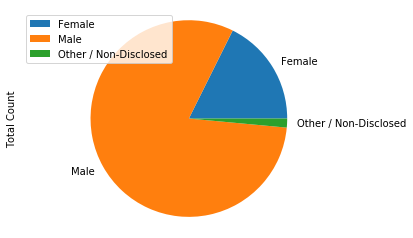

In [126]:
%matplotlib inline
gender_df.plot.pie("Total Count").axis("equal")

## Purchasing Analysis (Gender)

In [227]:
# Create a new df
purchasing_gender_df = pd.DataFrame({
    "Purchase Count": gender_df["Total Count"],
    "Average Purchase Price":gender["Price"].mean(),
    "Total Purchase Value":gender["Price"].sum(),
    "Normalized Totals":gender["Price"].mean()*gender["Price"].std()
})

#Format and Output
purchasing_gender_df[[
    "Purchase Count",
    "Average Purchase Price",
    "Total Purchase Value",
    "Normalized Totals"
]].style.format({
    "Average Purchase Price":"${:.2f}",
    "Total Purchase Value":"${:.2f}",
    "Normalized Totals":"${:.2f}"
})

,Purchase Count,Average Purchase Price,Total Purchase Value,Normalized Totals
Gender,,,,
Female,108,$2.93,$316.62,$3.30
Male,495,$3.00,$1486.37,$3.31
Other / Non-Disclosed,9,$3.30,$29.70,$2.79


## Age Demographics

In [228]:
# Set bins and labels
# print(purchase_df["Age"].min())
# print(purchase_df["Age"].max())
bins = [0,10,15,20,25,30,35,40,45]
group_labels = ["< 10","10 - 14","15 - 19","20 - 24","25 - 29","30 - 34","35 - 39","40 - 45"]
uniquePlayers_df["ageRange"] = pd.cut(uniquePlayers_df["Age"],bins,labels=group_labels)
# uniquePlayers_df.head()

# Group by ageRange
uniquePlayers_ageRange = uniquePlayers_df.groupby("ageRange")

# Format and Output
uniquePlayers_ageRange_df = pd.DataFrame({
    "Percentage of Players":uniquePlayers_ageRange["Age"].count()/totalCount,
    "Total Count": uniquePlayers_ageRange["Age"].count()
})
uniquePlayers_ageRange_df.style.format({
    "Percentage of Players": "{:.2%}"
})

/Users/tokunaga/.pyenv/versions/anaconda3-5.0.0/envs/PythonData/lib/python3.6/site-packages/ipykernel/__main__.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


,Percentage of Players,Total Count
ageRange,,
< 10,3.92%,24
10 - 14,9.31%,57
15 - 19,24.51%,150
20 - 24,40.20%,246
25 - 29,8.99%,55
30 - 34,7.84%,48
35 - 39,4.74%,29
40 - 45,0.49%,3


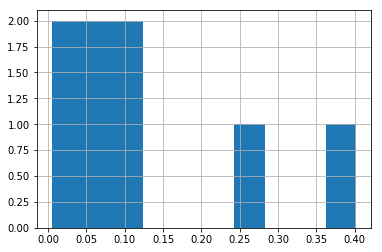

In [230]:
uniquePlayers_ageRange_df["Percentage of Players"].hist()
# TODO fix bug

## Purchasing Analysis (Age)

In [234]:
# Group by SN
dataBySN = purchase_df.groupby("SN").mean()

# Set bins and labels
bins = [0,10,15,20,25,30,35,40,45]
group_labels = ["< 10","10 - 14","15 - 19","20 - 24","25 - 29","30 - 34","35 - 39","40 - 45"]

# Add ageRange row using cut
dataBySN["ageRange"] = pd.cut(dataBySN["Age"],bins,labels=group_labels)

# Add other rows
dataBySN["purchasePrice"] = purchase_df.groupby("SN").mean()["Price"]
dataBySN["totalPrice"] = purchase_df.groupby("SN").sum()["Price"]
dataBySN["purchaseCount"] = purchase_df.groupby("SN").count()["Age"]
# dataBySN

# Group by ageRange
dataBySN_ageRange = dataBySN.groupby("ageRange")

# Create a new df
dataBySN_ageRange_df = pd.DataFrame({
    "User Count": uniquePlayers_ageRange_df["Total Count"],
    "Purchase Count": dataBySN_ageRange["purchaseCount"].sum(),
    "Average Purchase Price per once": dataBySN_ageRange["purchasePrice"].mean(),
    "Average Purchase Price per person": dataBySN_ageRange["totalPrice"].mean(),
    "Total Purchase Value": dataBySN_ageRange["totalPrice"].sum(),
    "Normalized Totals": dataBySN_ageRange["totalPrice"].mean()*dataBySN_ageRange["totalPrice"].std()
})

# Format and Output
dataBySN_ageRange_df[[
    "User Count",
    "Purchase Count",
    "Average Purchase Price per once",
    "Average Purchase Price per person",
    "Total Purchase Value",
    "Normalized Totals"
]].style.format({
    "Average Purchase Price per once":"${:.2f}",
    "Average Purchase Price per person":"${:.2f}",
    "Total Purchase Value":"${:.2f}",
    "Normalized Totals":"${:.2f}"
})

,User Count,Purchase Count,Average Purchase Price per once,Average Purchase Price per person,Total Purchase Value,Normalized Totals
ageRange,,,,,,
< 10,24,32,$3.25,$4.63,$101.90,$9.71
10 - 14,57,79,$2.89,$4.05,$226.83,$9.12
15 - 19,150,205,$2.88,$3.91,$586.40,$8.37
20 - 24,246,344,$2.97,$4.05,$1016.20,$9.02
25 - 29,55,82,$2.86,$4.19,$230.67,$11.12
30 - 34,48,69,$3.14,$4.35,$213.22,$10.79
35 - 39,29,44,$2.96,$5.02,$130.57,$15.58
40 - 45,3,3,$2.88,$2.88,$8.64,$2.48


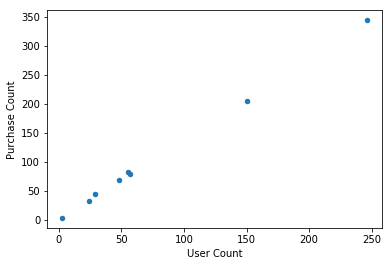

In [235]:
dataBySN_ageRange_df.plot.scatter(x='User Count', y='Purchase Count')

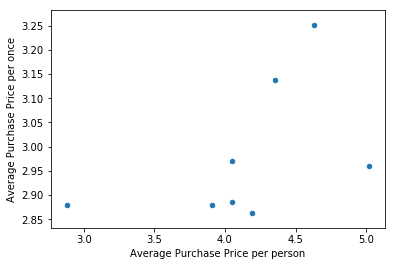

In [236]:
dataBySN_ageRange_df.plot.scatter(x='Average Purchase Price per person', y='Average Purchase Price per once')

## Top Spenders

In [237]:
# Group by SN
purchase_bySN = purchase_df.groupby("SN")

# Create a new df
topSpenders_df = pd.DataFrame({
    "Purchase Count" : purchase_bySN["Item ID"].count(),
    "Average Purchase Price": purchase_bySN["Price"].mean(),
    "Total Purchase Value": purchase_bySN["Price"].sum()
})

# Sort, Format, and Output
topSpenders_df[[
    "Purchase Count",
    "Average Purchase Price",
    "Total Purchase Value"
]].sort_values(
    by=["Purchase Count", "Average Purchase Price"],
    ascending=False
).head().style.format({
    "Average Purchase Price":"${:.2f}",
    "Total Purchase Value":"${:.2f}"
})


,Purchase Count,Average Purchase Price,Total Purchase Value
SN,,,
Undirrala66,5,$3.41,$17.06
Aerithllora36,4,$3.77,$15.10
Saedue76,4,$3.39,$13.56
Sondim43,4,$3.25,$13.02
Mindimnya67,4,$3.18,$12.74


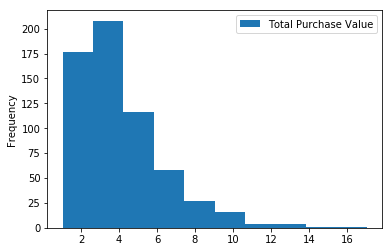

In [238]:
%matplotlib inline
topSpenders_df.plot.hist(x='Purchase Count', y='Total Purchase Value')

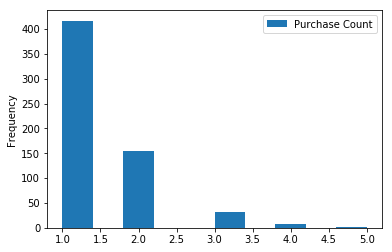

In [239]:
%matplotlib inline
topSpenders_df.plot.hist(x='Total Purchase Value', y='Purchase Count')

## Most Popular Items

In [240]:
# Group by Item ID and Item Name
purchase_byItem = purchase_df.groupby(["Item ID","Item Name"])

# Create a new df
topItem_df = pd.DataFrame({
    "Purchase Count":purchase_byItem["SN"].count(),
    "Item Price":purchase_byItem["Price"].mean(),
    "Total Purchase Value":purchase_byItem["Price"].sum()
})

# Sort by Purchase Count, Format, and Output
topItem_df[[
    "Purchase Count",
    "Item Price","Total Purchase Value"
]].sort_values(
    by=["Purchase Count", "Total Purchase Value"],
    ascending=False
).head().style.format({
    "Item Price": "${:.2f}",
    "Total Purchase Value": "${:.2f}"
})

,,Purchase Count,Item Price,Total Purchase Value
Item ID,Item Name,,,
84,Arcane Gem,12,$2.45,$29.34
39,"Betrayal, Whisper of Grieving Widows",11,$2.35,$25.85
31,Trickster,10,$2.32,$23.22
34,Retribution Axe,9,$4.14,$37.26
107,"Splitter, Foe Of Subtlety",9,$3.67,$33.03


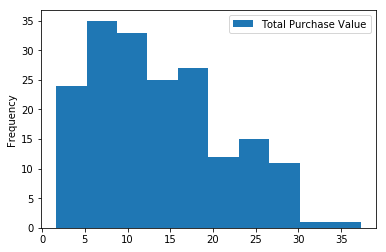

In [244]:
topItem_df.plot.hist(x='Purchase Count', y='Total Purchase Value')

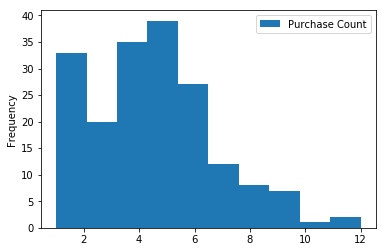

In [245]:
topItem_df.plot.hist(x='Total Purchase Value', y='Purchase Count')

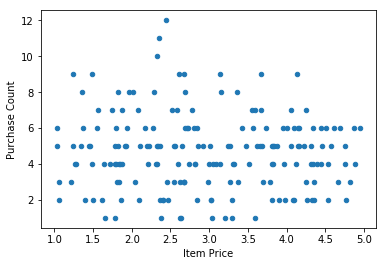

In [246]:
topItem_df.plot.scatter(x='Item Price', y='Purchase Count')

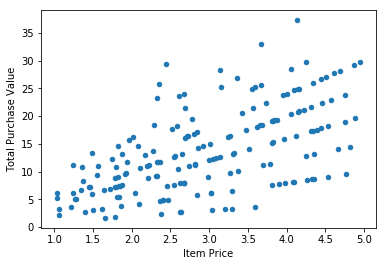

In [247]:
topItem_df.plot.scatter(x='Item Price', y='Total Purchase Value')

## Most Profitable Items

In [248]:
# Sort by Total Purchase Value, Format and Output
topItem_df[[
    "Purchase Count",
    "Item Price",
    "Total Purchase Value"
]].sort_values(
    by=["Total Purchase Value", "Item Price"],
    ascending=False
).head().style.format({
    "Item Price": "${:.2f}",
    "Total Purchase Value": "${:.2f}"
})

,,Purchase Count,Item Price,Total Purchase Value
Item ID,Item Name,,,
34,Retribution Axe,9,$4.14,$37.26
107,"Splitter, Foe Of Subtlety",9,$3.67,$33.03
115,Spectral Diamond Doomblade,7,$4.25,$29.75
32,Orenmir,6,$4.95,$29.70
84,Arcane Gem,12,$2.45,$29.34
